### `import` Packages

In [ ]:
! pip install distance fuzzywuzzy

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')

import os
import re
import distance

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
from matplotlib import style

style.use('seaborn-deep')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
folder_path = '/content/drive/MyDrive/AAIC/QQP/'

In [ ]:
STOP_WORDS = stopwords.words("english")

### Data Reading

In [ ]:
# if os.path.isfile(folder_path + 'df_fe_without_preprocessing_train.csv'):
#     df = pd.read_csv(folder_path + 'df_fe_without_preprocessing_train.csv', encoding='latin-1')
#     df = df.fillna('')
#     df.head()
# else:
#     print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

df = pd.read_csv(folder_path + 'train.csv')

In [ ]:
df.shape

(404290, 6)

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Text Preprocessing

* Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions (de-contract)

In [ ]:
def preprocess_text(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m")\
         .replace(",000", "k")\
         .replace("′", "'")\
         .replace("’", "'")\
         .replace("won't", "will not")\
         .replace("cannot", "can not")\
         .replace("can't", "can not")\
         .replace("n't", " not")\
         .replace("what's", "what is")\
         .replace("it's", "it is")\
         .replace("'ve", " have")\
         .replace("i'm", "i am")\
         .replace("'re", " are")\
         .replace("he's", "he is")\
         .replace("she's", "she is")\
         .replace("'s", " own")\
         .replace("%", " percent ")\
         .replace("₹", " rupee ")\
         .replace("$", " dollar ")\
         .replace("€", " euro ")\
         .replace("'ll", " will")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if (type(x) == type('')):
        x = re.sub(pattern, ' ', x)
    
    if (type(x) == type('')):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
    
    return x

### Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:
- __Token__: You get a token by splitting sentence a space.
- __Stopword__ : stop words as per NLTK.
- __Word__ : A token that is not a stopword.

Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br> cwc_min = common_word_count / (min(len(q1_words), len(q2_words))

- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br> cwc_max = common_word_count / (max(len(q1_words), len(q2_words))

- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))

- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2 <br> csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))

- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2 <br> ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2 <br> ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
        
- __last_word_eq__ :  Check if Last word of both questions is equal or not <br> last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])

- __first_word_eq__ :  Check if First word of both questions is equal or not <br> first_word_eq = int(q1_tokens[0] == q2_tokens[0])
        
- __abs_len_diff__ :  Abs. length difference <br> abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))

- __mean_len__ :  Average Token Length of both Questions <br> mean_len = (len(q1_tokens) + len(q2_tokens))/2

- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2 <br> longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [ ]:
class ExtractFreatures:
    def __init__(self, df, cols, stopwords):
        self.df = df
        self.col1, self.col2 = cols[0], cols[1]
        self.stopwords = stopwords
        self.SAFE_DIV = 0.0001
        self.token_size = 10
    
    def get_token_features(self, tup):
        '''
        q1 : refers to a question (sentence) from question1
        q2 : refers to a question (sentence) from question2
        '''
        q1, q2 = tup
        token_features = np.zeros(shape=self.token_size)

        # converting the sentence into tokens
        q1_all = q1.split(' ')
        q2_all = q2.split(' ')
        q1_tokens = set(q1_all)
        q2_tokens = set(q2_all)

        if (len(q1_tokens) == 0) or (len(q2_tokens) == 0):
            return token_features
        
        # get non-stopwards from question tokens
        q1_words = set([word for word in q1_tokens if word not in self.stopwords])
        q2_words = set([word for word in q2_tokens if word not in self.stopwords])

        # get the stopwords from question tokens
        q1_stops = set([word for word in q1_tokens if word in self.stopwords])
        q2_stops = set([word for word in q2_tokens if word in self.stopwords])

        # get the common non-stopwords count from q1_words and q2_words
        cwc = len(q1_words.intersection(q2_words))
        cwc_min = cwc / (min(len(q1_words), len(q2_words)) + self.SAFE_DIV)
        cwc_max = cwc / (max(len(q1_words), len(q2_words)) + self.SAFE_DIV)

        # get the common stopwords count from q1_stops and q2_stops
        csc = len(q1_stops.intersection(q2_stops))
        csc_min = csc / (min(len(q1_stops), len(q2_stops)) + self.SAFE_DIV)
        csc_max = csc / (max(len(q1_stops), len(q2_stops)) + self.SAFE_DIV)

        # get the common token count from q1_tokens and q2_tokens
        ctc = len(q1_tokens.intersection(q2_tokens))
        ctc_min = csc / (min(len(q1_tokens), len(q2_tokens)) + self.SAFE_DIV)
        ctc_max = csc / (max(len(q1_tokens), len(q2_tokens)) + self.SAFE_DIV)

        # last word of q1_all and q2_all is same or not
        last_word_eq = int(q1_all[-1] == q2_all[-1])
        # first word of q1_all and q2_all is same or not
        first_word_eq = int(q1_all[0] == q2_all[0])
        # absolute difference
        abs_diff_len = abs(len(q1_all) - len(q2_all))
        # average token length of q1_all and q2_all
        mean_len = np.mean([len(q1_all), len(q2_all)])

        # updating the token features
        token_features = np.array([cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_diff_len, mean_len])

        return token_features
    
    def get_fuzzy_features(self, tup):
        q1, q2 = tup
        # fuzzy features
        fuzz_ratio = fuzz.QRatio(q1, q2)
        fuzz_partial_ratio = fuzz.partial_ratio(q1, q2)
        fuzz_token_sort_ratio = fuzz.token_sort_ratio(q1, q2)
        fuzz_token_set_ratio = fuzz.token_set_ratio(q1, q2)
        fuzzy_features = np.array([fuzz_token_set_ratio, fuzz_token_sort_ratio, fuzz_ratio, fuzz_partial_ratio])
        return fuzzy_features
    
    def get_longest_substring_ratio(self, tup):
        q1, q2 = tup
        # longest substring ratio
        strs = list(distance.lcsubstrings(seq1=q1, seq2=q2))
        if len(strs) == 0:
            return 0
        return len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    def featurize_df(self):
        print("Preprocessing {} data".format(self.col1))
        questions1_all = self.df[self.col1].fillna("").apply(func=preprocess_text).to_list()
        print("Preprocessing {} data".format(self.col2))
        questions2_all = self.df[self.col2].fillna("").apply(func=preprocess_text).to_list()
        print("Zipping the preprocessed data")
        questions_tup = list(zip(questions1_all, questions2_all))

        print("Extracting tokenized features")
        token_features = np.matrix(list(map(self.get_token_features, questions_tup)))
        print("Extraction fuzzy features")
        fuzzy_features = np.matrix(list(map(self.get_fuzzy_features, questions_tup)))
        print("Fetching the longest substring ratio")
        l_substring_ratio = np.array(list(map(self.get_longest_substring_ratio, questions_tup))).reshape(-1, 1)
        
        print("Horizontal stacking the data")
        features_extracted = np.hstack(tup=(token_features, fuzzy_features, l_substring_ratio))
        features_cols = ['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_diff_len', 
                         'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio']
        features_df = pd.DataFrame(data=features_extracted, columns=features_cols)
        new_df = pd.concat([self.df, features_df], axis=1)

        return new_df

In [ ]:
if os.path.isfile(folder_path + 'nlp_features_train.csv'):
    df = pd.read_csv(folder_path + 'nlp_features_train.csv', encoding='latin-1')
else:
    ef = ExtractFreatures(df=df, cols=['question1', 'question2'], stopwords=STOP_WORDS)
    df = ef.featurize_df()
    df.to_csv(folder_path + 'nlp_features_train.csv', index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


### Data Splitting based on `is_duplicate` label

In [ ]:
df_duplicate = df[df['is_duplicate'] == 1]
df_unique = df[df['is_duplicate'] != 1]

In [ ]:
p = np.dstack((df_duplicate['question1'], df_duplicate['question2'])).flatten()
n = np.dstack((df_unique['question1'], df_unique['question2'])).flatten()

In [ ]:
print("Number of data points in class 1 (duplicate pairs) : ", len(p))
print("Number of data points in class 0 (non duplicate pairs) : ", len(n))

Number of data points in class 1 (duplicate pairs) :  298526
Number of data points in class 0 (non duplicate pairs) :  510054


In [ ]:
if os.path.isfile(folder_path + 'train_p.txt') and os.path.isfile(folder_path + 'train_n.txt'):
    print("Files already present")
    pass
else:
    print("Writing data into files")
    np.savetxt(folder_path + 'train_p.txt', p, delimiter=' ', fmt='%s')
    np.savetxt(folder_path + 'train_n.txt', n, delimiter=' ', fmt='%s')

Files already present


In [ ]:
with open(file=folder_path + 'train_p.txt', encoding='latin-1') as tr_p:
    textp_w = tr_p.read()

with open(file=folder_path + 'train_n.txt', encoding='latin-1') as tr_n:
    textn_w = tr_n.read()

In [ ]:
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")

print("Total number of words in duplicate pair questions : ", len(textp_w))
print("Total number of words in non duplicate pair questions : ", len(textn_w))

Total number of words in duplicate pair questions :  16109886
Total number of words in non duplicate pair questions :  33193130


### WordCloud for duplicate pair of questions

Word Cloud for Duplicate Question pairs


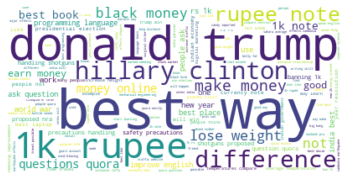

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### WordCloud for non-duplicate pair of questions

Word Cloud for Non-Duplicate Question pairs


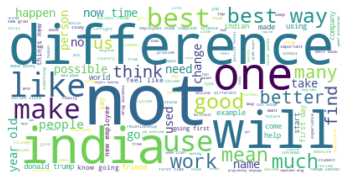

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
print("Word Cloud for Non-Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

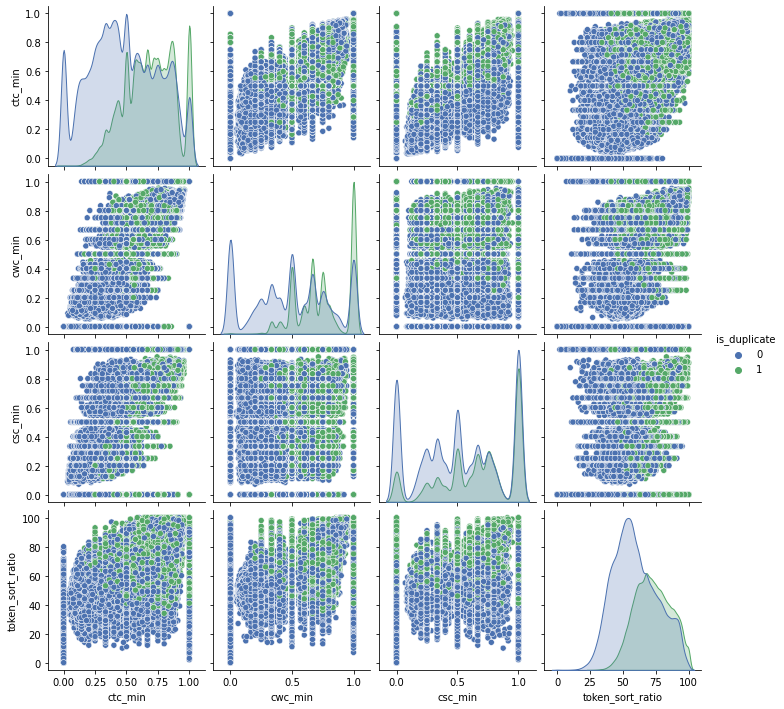

In [ ]:
n = df.shape[0]
sns.pairplot(
    df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], 
    hue='is_duplicate', 
    vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']
)
plt.show()

### Uni-Variate Analysis - `token_sort_ratio`

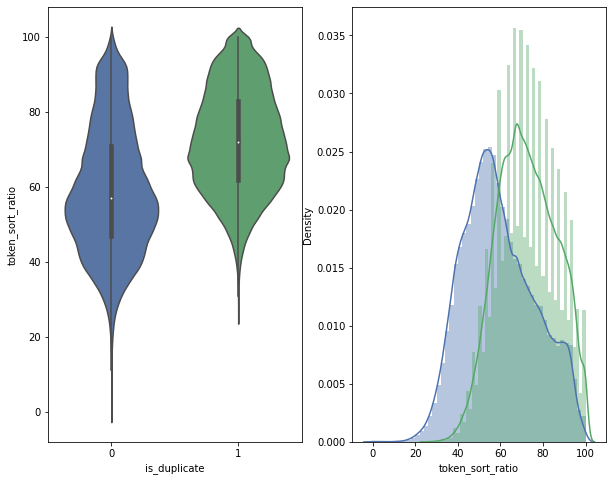

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='token_sort_ratio', data=df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:], label="0")
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:], label="1")
plt.show()

### Uni-Variate Analysis - `fuzz_ratio`

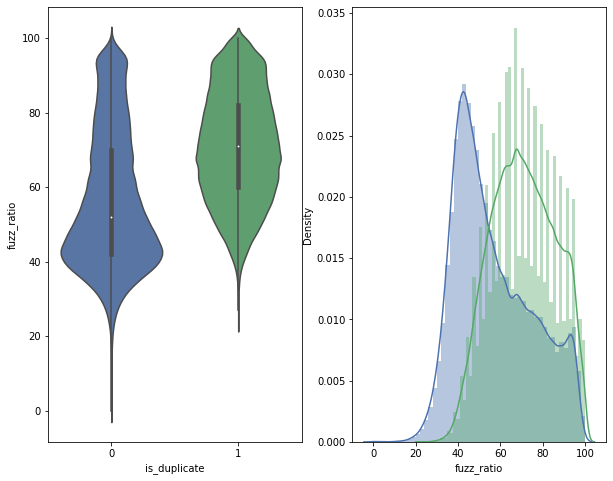

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='fuzz_ratio', data=df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:], label="0")
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:], label="1")
plt.show()

### T-SNE Data Visualization

In [ ]:
dfp_subsampled = df[0:5000]
features_cols = ['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 
                 'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio']
X = MinMaxScaler().fit_transform(dfp_subsampled[features_cols])
y = dfp_subsampled['is_duplicate'].values

**TSNE 2D**

In [ ]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.021s...
[t-SNE] Computed neighbors for 5000 samples in 0.390s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.320s
[t-SNE] Iteration 50: error = 80.9634247, gradient norm = 0.0451379 (50 iterations in 2.517s)
[t-SNE] Iteration 100: error = 70.4310913, gradient norm = 0.0098959 (50 iterations in 1.821s)
[t-SNE] Iteration 150: error = 68.6403122, gradient norm = 0.0059423 (50 iterations in 1.839s)
[t-SNE] Iteration 200: error = 67.7985153, gradient norm = 0.0040715 (50 iterations in 1.842s)
[t-SNE] Iteration 250: error = 67.3001938, gradient norm = 0.0031636

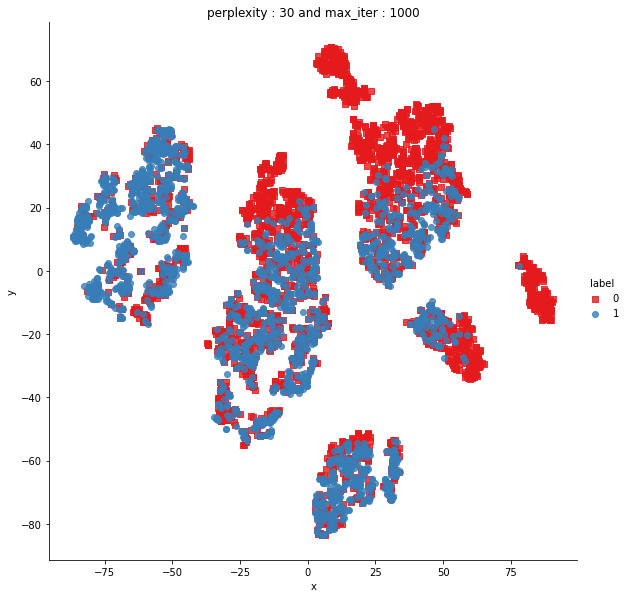

In [ ]:
tsne2d_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=tsne2d_df, x='x', y='y', hue='label', fit_reg=False, size=8, palette="Set1", markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

**TSNE 3D**

In [ ]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.031s...
[t-SNE] Computed neighbors for 5000 samples in 0.520s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.342s
[t-SNE] Iteration 50: error = 80.3825836, gradient norm = 0.0316220 (50 iterations in 10.381s)
[t-SNE] Iteration 100: error = 69.1291580, gradient norm = 0.0034171 (50 iterations in 5.123s)
[t-SNE] Iteration 150: error = 67.6390839, gradient norm = 0.0017523 (50 iterations in 4.639s)
[t-SNE] Iteration 200: error = 67.0798187, gradient norm = 0.0011316 (50 iterations in 4.571s)
[t-SNE] Iteration 250: error = 66.7545319, gradient norm = 0.001095

In [ ]:
trace = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color=y,
        colorscale='Portland',
        colorbar=dict(title='duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

layout = go.Layout(
    height=600,
    width=600,
    title='3d embedding with engineered features',
    margin=dict(l=0, r=0, t=40, b=0)
)

fig = go.Figure(data=[trace], layout=layout)
fig.show()